In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
import prepare_data_functions as t
import seaborn as sns
%matplotlib inline

cf = pd.read_csv('./boston/calendar.csv')
lf = pd.read_csv('./boston/listings.csv')
rf = pd.read_csv('./boston/reviews.csv')

lf.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,2.016090e+13,9/7/16,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,2.016090e+13,9/7/16,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,2.016090e+13,9/7/16,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,2.016090e+13,9/7/16,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,2.016090e+13,9/7/16,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [2]:
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [3]:
num_vars = lf[['price', 'bathrooms', 'bedrooms', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'reviews_per_month', 'number_of_reviews', 'accommodates']]
drop_aval_df = num_vars.dropna(subset=['price'], axis=0)


drop_aval_df['price'] = drop_aval_df['price'].apply(clean_currency).astype('float')

In [10]:
lf['price'] = lf['price'].apply(clean_currency).astype('float')

In [11]:
print(lf['price'])

0       250.0
1        65.0
2        65.0
3        75.0
4        79.0
        ...  
3580     69.0
3581    150.0
3582    198.0
3583     65.0
3584     65.0
Name: price, Length: 3585, dtype: float64


In [62]:
def clean_data(df):
    # Drop rows with missing salary values
    df = df.dropna(subset=['price'], axis=0)
    y = df['price']
    
    #Drop respondent and expected salary columns
    #df = df.drop(['Respondent', 'ExpectedSalary', 'Salary'], axis=1)
#     df = df.drop(['host_has_profile_pic_t','last_review_9/8/15', 'last_review_9/9/15', 'instant_bookable_t', 'require_guest_phone_verification_t', 'require_guest_profile_picture_t', 'scrape_id', 'host_id', 'id', 'host_total_listings_count','host_total_listings_count','neighbourhood_group_cleansed','latitude','longitude','review_scores_accuracy','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','jurisdiction_names','calculated_host_listings_count', 'price'], axis=1)
    df = df.drop(['host_response_rate', 'host_verifications','calendar_updated', 'transit', 'neighborhood_overview', 'notes', 'access', 'host_acceptance_rate', 'host_location','interaction', 'host_picture_url', 'host_name', 'host_since', 'host_thumbnail_url', 'host_about', 'host_url', 'host_thumbnail_url', 'host_about', 'scrape_id', 'host_id', 'id', 'host_total_listings_count','host_total_listings_count','neighbourhood_group_cleansed','latitude','longitude','review_scores_accuracy','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','jurisdiction_names','calculated_host_listings_count', 'price'], axis=1)
   
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    #df.shape
    #print(df.shape)
    return X, y
    
#Use the function to create X and y
X, y = clean_data(lf)    

In [63]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        print(lf.shape)
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        print(y_train_preds)

        #append the r2 value from the test set
        
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_f_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


In [52]:
# print(X_train)

(3585, 95)
[271.13228788 190.2911934  121.7828338  ... 106.01369678 104.89556578
 128.01248433]
(3585, 95)
[241.63354867 182.62150039 144.43227763 ... 108.03201731 105.54456679
 128.21740361]
(3585, 95)
[206.00411903 183.55583398 164.55583398 ... 108.30895803 107.30895803
 129.30895803]
(3585, 95)
[198.96565627 192.87561851 125.62089267 ...  66.54964411  65.40123792
  89.77481682]
(3585, 95)
[200.32080523 261.53995553 102.64662953 ...  41.38393063  40.61251893
 104.60141445]
(3585, 95)
[187.99450794 280.20914562  88.42341659 ...  29.95519018  44.44064756
 100.88411937]
(3585, 95)
[197.10362545 279.1423602   95.79279752 ...   7.36250298  55.65259127
 109.97001394]
(3585, 95)
[192.89536704 279.23478253  95.98291153 ...   7.81305515  60.39066756
 108.13461961]


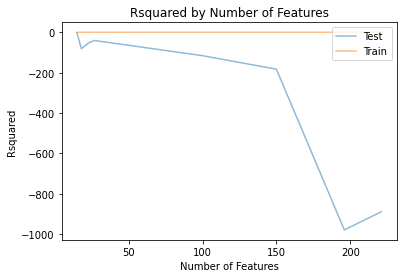

The rsquared on the training data was [0.24984514176321915, 0.2607866677815427, 0.2756142150081802, 0.3301815985248634, 0.4335654884478136, 0.4697567053327466, 0.4811844587079447, 0.48713620377773226].  The rsquared on the test data was [-2.2161084502214603, -81.02992347460729, -52.00731712891333, -40.45410037406445, -115.59337970595428, -182.49635269591096, -978.8583177656178, -888.8190301645399].


In [79]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r2_scores_train, r2_scores_test))

In [80]:
def coef_weights(coefficients, X_train):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
97,city_Boston,1.462781e+15,1.462781e+15
123,"smart_location_Boston, MA",-1.462781e+15,1.462781e+15
218,cancellation_policy_super_strict_30,1.943447e+02,1.943447e+02
93,neighbourhood_cleansed_South Boston Waterfront,1.457309e+02,1.457309e+02
112,zipcode_2127,-1.295057e+02,1.295057e+02
58,"street_Seaport Boulevard, Boston, MA 02210, Un...",-1.201786e+02,1.201786e+02
92,neighbourhood_cleansed_South Boston,1.062272e+02,1.062272e+02
78,neighbourhood_cleansed_Beacon Hill,9.268629e+01,9.268629e+01
114,zipcode_2129,8.079913e+01,8.079913e+01
34,host_neighbourhood_Gay Village,7.763850e+01,7.763850e+01
